# Imports and constants

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp


R = 6371e3 # Earths mean radius [m] 
B_0 = 3.12e-5 # Earths mean magnetic field strength [T]
e = 1.602e-19 # Elementary charge [C]
m_p = 1.672e-27 # Proton mass [kg]
m = 8*10**2 * np.array([np.sin(np.radians(11 + 23.5)), 0, np.cos(np.radians(11 + 23.5))]) # Dipole moment unit vector (tilted 34.5° from z-axis)
mu_0 = 1.2e-6


First we approximate the earths magnetic field to a dipole, using a formula from Griffits. We can replace the magnetic moment with its unit vector and a constant for the B-field. We set B_0 from the wikipedia page for the earth as a dipole.

In [219]:
def get_B_field(pos): 
#    x,y,z = pos
    r_vec = np.array(pos)
    r = np.linalg.norm(pos)
    
#    theta = np.atan(z/x + np.radians(11 + 23.5))
#    B_r = - 2 * B_0 *(R/r)**3*np.cos(theta)
#    B_theta = - B_0 (R/r)**3*np.sin(theta)

    if r<R:
        return np.array([0,0,0])
    
    r_hat = r_vec/r

    B_vec = mu_0/(4*np.pi) * (3 * ( np.dot(m,r_hat))*r_hat - m)/r**3



    return B_vec


# Plots

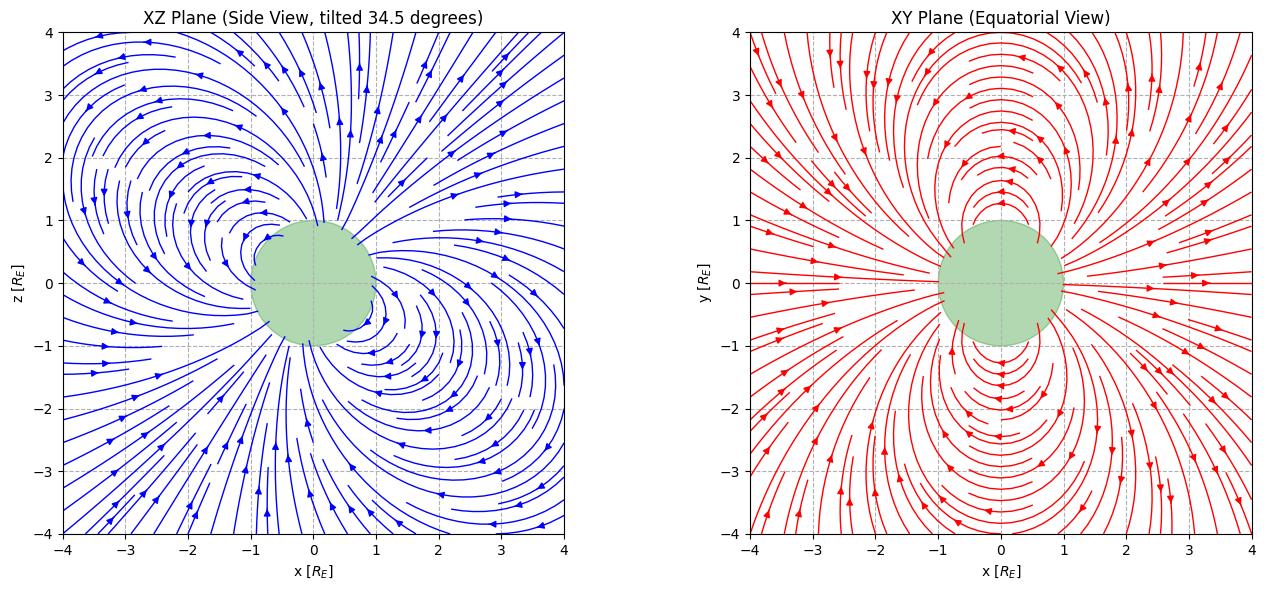

In [220]:
limit = 4 * R
points = 50
coords = np.linspace(-limit, limit, points)
X_grid, Z_grid = np.meshgrid(coords, coords)

Bx_xz = np.zeros_like(X_grid)
Bz_xz = np.zeros_like(Z_grid)

Bx_xy = np.zeros_like(X_grid)
By_xy = np.zeros_like(Z_grid)

# Calculate field at each point
for i in range(points):
    for j in range(points):
        b_xz = get_B_field(np.array([X_grid[i,j], 0, Z_grid[i,j]]))
        Bx_xz[i,j], Bz_xz[i,j] = b_xz[0], b_xz[2]
        
        b_xy = get_B_field(np.array([X_grid[i,j], Z_grid[i,j], 0]))
        Bx_xy[i,j], By_xy[i,j] = b_xy[0], b_xy[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# XZ Plane
ax1.streamplot(X_grid/R, Z_grid/R, Bx_xz, Bz_xz, color='blue', linewidth=1, density=1.5)
ax1.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3, label='Earth'))
ax1.set_title("XZ Plane (Side View, tilted 34.5 degrees)")
ax1.set_xlabel("x [$R_E$]")
ax1.set_ylabel("z [$R_E$]")

# XY Plane 
ax2.streamplot(X_grid/R, Z_grid/R, Bx_xy, By_xy, color='red', linewidth=1, density=1.5)
ax2.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3))
ax2.set_title("XY Plane (Equatorial View)")
ax2.set_xlabel("x [$R_E$]")
ax2.set_ylabel("y [$R_E$]")

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

# Simulating the solar wind

In [221]:
def euler_solve_ivp(pos, v, dt):
    B = get_B_field(pos)
    a = e * np.cross(v, B) / m_p
    v_new = v + a * dt
    pos_new = pos + v_new * dt
    return pos_new, v_new



In [222]:


# Initial Conditions
pos = np.array([-2*R, 0, 0]) 
v = np.array([4_00_000, 0, 0])  
t_end = 10
dt = 1e-5
t_eval = np.arange(0,t_end,dt)
                  


trajectory = [pos]


speed = []

for t in t_eval:
    pos, v = euler_solve_ivp(pos, v, dt)

    trajectory.append(pos)

    speed.append(np.linalg.norm(v))

trajectory = np.array(trajectory)


-12742000.0 -8742000.0


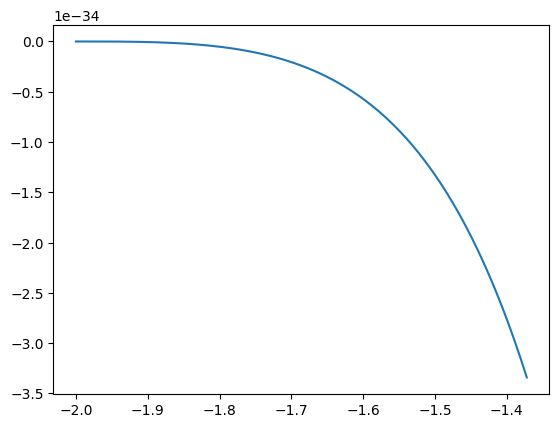

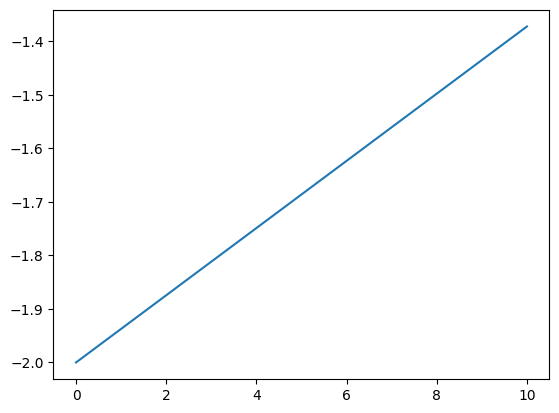

In [223]:
x,y,z = trajectory[:,0],trajectory[:,1],trajectory[:,2]
print(x[0],x[-1])
plt.plot(x/R, z/R)
plt.show()
plt.plot(t_eval,x[:-1]/R)
plt.show()


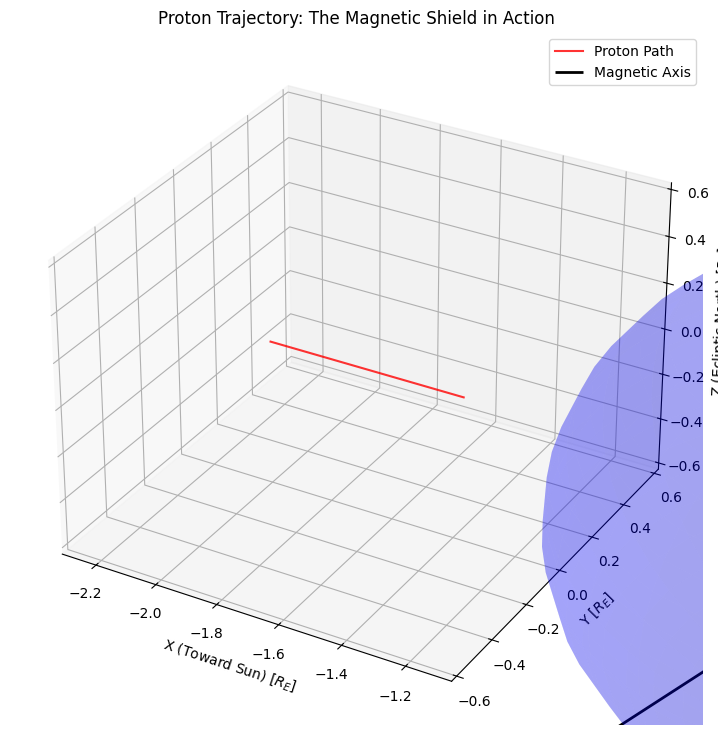

In [224]:
def plot_trajectory_fixed(trajectory, m_hat):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # 1. Plot the Trajectory
    ax.plot(trajectory[:, 0]/R, trajectory[:, 1]/R, trajectory[:, 2]/R, 
            label='Proton Path', color='red', linewidth=1.5, alpha=0.8)

    # 2. Draw Earth as a sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_earth = np.outer(np.cos(u), np.sin(v))
    y_earth = np.outer(np.sin(u), np.sin(v))
    z_earth = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.2)

    # 3. Draw the Magnetic Dipole Axis
    ax.quiver(0, 0, 0, m_hat[0]*1.5, m_hat[1]*1.5, m_hat[2]*1.5, 
              color='black', label='Magnetic Axis', linewidth=2)

    # FIXED: Corrected label methods
    ax.set_xlabel('X (Toward Sun) [$R_E$]')
    ax.set_ylabel('Y [$R_E$]')
    ax.set_zlabel('Z (Ecliptic North) [$R_E$]') # No underscore after 'z'
    
    # Set equal scale
    max_range = np.array([trajectory[:,0].max()-trajectory[:,0].min(), 
                         trajectory[:,1].max()-trajectory[:,1].min(), 
                         trajectory[:,2].max()-trajectory[:,2].min()]).max() / (2.0 * R)
    
    mid_x = (trajectory[:,0].max()+trajectory[:,0].min())/(2.0*R)
    mid_y = (trajectory[:,1].max()+trajectory[:,1].min())/(2.0*R)
    mid_z = (trajectory[:,2].max()+trajectory[:,2].min())/(2.0*R)
    
    ax.set_xlim(mid_x - 2*max_range, mid_x + 2*max_range)
    ax.set_ylim(mid_y - 2*max_range, mid_y + 2*max_range)
    ax.set_zlim(mid_z - 2*max_range, mid_z + 2*max_range)

    ax.set_title('Proton Trajectory: The Magnetic Shield in Action')
    ax.legend()
    plt.show()

plot_trajectory_fixed(trajectory, m)